In [120]:
import pandas as pd 
from conexion import open_conexion_get,desencriptar_archivo, obtener_ip_publica
from fechas import *
from datetime import timedelta
from fn_prep import *
import ta
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
# Prueba de hipotesis
from scipy import stats
import numpy as np
from plotting import *

In [34]:
obtener_ip_publica()

Mi dirección IP pública es: 189.217.196.221


In [35]:
sucesion_fib(4)

1
1
2
3


In [36]:
# Lee la clave hash para desencriptar
with open('/home/hector/Documentos/Escuelas/Autodidacta/Trading/Data/clave.key', 'r') as clave_file:
    clave = clave_file.read()
# Lee las contraseñas del archivo encriptado y muestra el resultado deseado
contraseñas = desencriptar_archivo('Data/credenciales.txt', clave)

In [154]:
con = open_conexion_get('HectorLP5',contraseñas['MYSQL_PASSW'],database='BNB')

In [38]:
intervalos = ["1d","12h","8h","6h","4h","2h","1h"]
simbolos = ['BTCUSDT','TRXUSDT',"BNBUSDT","XRPUSDT","ETHUSDT"]
# BNB: ['BNBBTC', 'BNBETH', 'BNBUSDT', 'BNBTUSD', 'BNBUSDC', 'BNBBUSD',
#       'BNBRUB', 'BNBTRY', 'BNBEUR', 'BNBGBP', 'BNBBIDR', 'BNBDAI',
#       'BNBBRL', 'BNBUAH', 'BNBFDUSD']

In [155]:
interval = "4h"
symbol = "BNBETH"
table_name = symbol +'_'+ interval
#con = sqlite3.connect('Data/'+symbol)

df = pd.read_sql_query(f"""
                      SELECT *
                      FROM {table_name}
                      """, con)

df.Name = table_name
df.Close_Time = df.Close_Time #+ timedelta(seconds=1)
# Hacer index la fecha
df = df.set_index("Close_Time")
# Hacer respaldo 
df_respaldo = df.copy()
df.shape

(8146, 10)

In [156]:
df = df_respaldo.copy()

# Analizar del 2022 al ultimo
df = df[df.index > '2020-01-01']
df.tail()


,Open_Time,Open,High,Low,Close,Volumne,Quote_asset_vol,Number_trades,Taker_buy_base,Taker_buy_quote
Close_Time,,,,,,,,,,
2023-09-19 06:00:00,2023-09-19 02:00:00,0.1326,0.1330,0.1316,0.1324,2072.564,274.577929,1449,1280.343,169.703195
2023-09-19 10:00:00,2023-09-19 06:00:00,0.1325,0.1329,0.1316,0.1318,1696.634,224.459079,1655,1036.343,137.144646
2023-09-19 14:00:00,2023-09-19 10:00:00,0.1318,0.1322,0.1316,0.1320,504.964,66.577313,777,245.660,32.401157
2023-09-19 18:00:00,2023-09-19 14:00:00,0.1320,0.1324,0.1319,0.1322,435.861,57.603659,715,219.278,28.986107
2023-09-19 22:00:00,2023-09-19 18:00:00,0.1321,0.1322,0.1319,0.1319,93.848,12.395601,146,64.752,8.554184


In [41]:
df_respaldo.tail(4)

,Open_Time,Open,High,Low,Close,Volumne,Quote_asset_vol,Number_trades,Taker_buy_base,Taker_buy_quote
Close_Time,,,,,,,,,,
2023-09-19 10:00:00,2023-09-19 06:00:00,0.008014,0.008050,0.007941,0.007961,6426.224,51.413092,7952,2934.947,23.475277
2023-09-19 14:00:00,2023-09-19 10:00:00,0.007960,0.008006,0.007952,0.007979,3182.359,25.407362,4627,1568.056,12.515532
2023-09-19 18:00:00,2023-09-19 14:00:00,0.007980,0.008007,0.007974,0.007981,2356.972,18.826701,3219,1122.303,8.964212
2023-09-19 22:00:00,2023-09-19 18:00:00,0.007981,0.007981,0.007968,0.007972,185.066,1.475613,349,80.435,0.641219


In [157]:
con.close()

# Indicadores tecnicos

## Media  movil 

Trend Indicators 

These indicators help traders identify the direction and strength of a market trend. They typically measure the asset's price movement over time and help traders determine if a trend is bullish (upward) or bearish (downward).

Example: Moving Averages (MA)
Moving averages smooth out price data by calculating the average price of an asset over a specified time period. Popular types of moving averages include the Simple Moving Average (SMA) and the Exponential Moving Average (EMA). Traders often use moving averages to identify trends and potential entry/exit points.

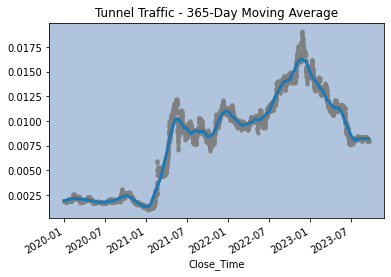

In [44]:
# Version manual
col = 'Close'
moving_average = df[col].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)


ax = df[col].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

In [45]:
# Version libreria ta.
col_use = "Close"
df = put_EMA(df,col_use,periodos=[8,13,55,144])
df.columns

Index(['Open_Time', 'Open', 'High', 'Low', 'Close', 'Volumne',
       'Quote_asset_vol', 'Number_trades', 'Taker_buy_base', 'Taker_buy_quote',
       'EMA8', 'EMA13', 'EMA55', 'EMA144'],
      dtype='object')

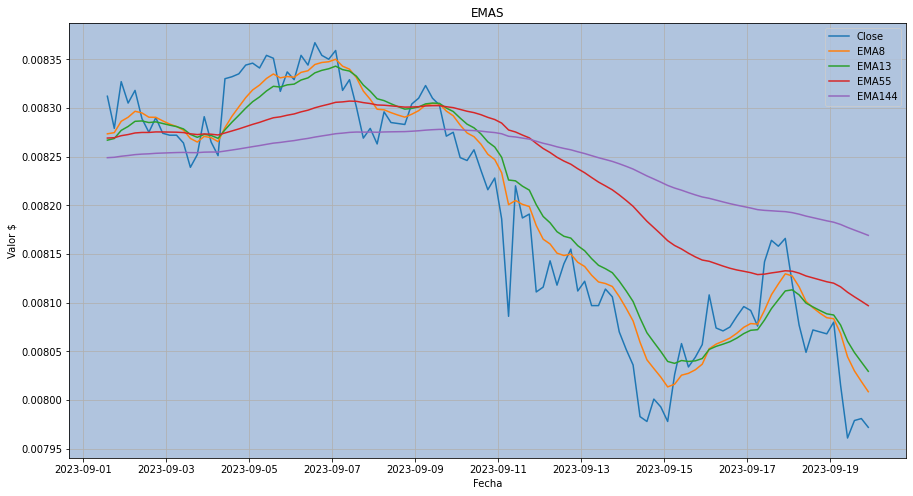

In [46]:
# Graficar EMA's
start_date = '2023-09-01 10:00:00'
df_plot = df[df.index>start_date].copy()

columns = ["Close",'EMA8', 'EMA13', 'EMA55', 'EMA144']

plot_line(df_plot,columns,
            figsize=(15, 8),title="EMAS")

## Bandas bollinguer
Volatility Indicators
> These indicators measure the degree of price fluctuations and help traders gauge market sentiment and potential price breakouts.

> Bollinger Bands consist of a centerline (typically an SMA) and two outer bands, which are standard deviations above and below the centerline. The bands expand and contract based on market volatility. When the bands are narrow, volatility is low, and when they widen, volatility is high. Traders use Bollinger Bands to identify potential entry/exit points and overbought/oversold conditions.


| <img src="https://a.c-dn.net/b/3u3xku/trading-forex-with-bollinger-bands_body_Mainimage.png" width="50%" alt="BB image credit:https://www.dailyfx.com/">|
|:--:| 
| An example of MACD indicator *image credit: https://www.dailyfx.com/* |

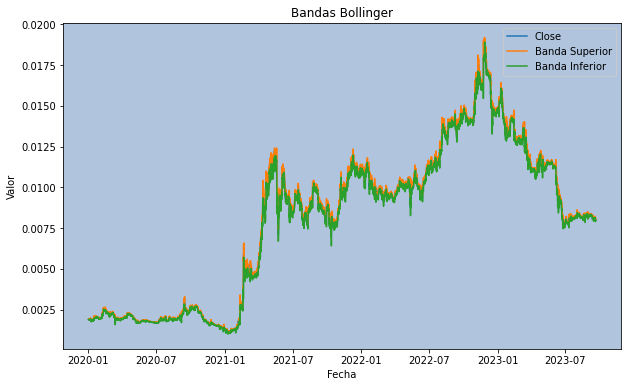

In [47]:
# Version manual
import matplotlib.pyplot as plt

def calcular_bandas_bollinger(datos, ventana, desviacion):
    datos['Media'] = datos['Close'].rolling(window=ventana).mean()
    datos['Desviacion'] = datos['Close'].rolling(window=ventana).std()
    datos['BandaSuperior'] = datos['Media'] + (datos['Desviacion'] * desviacion)
    datos['BandaInferior'] = datos['Media'] - (datos['Desviacion'] * desviacion)
    return datos

def analizar_bandas(datos,col_use='Close'):
    señales = []
    for i in range(len(datos)):
        if datos[col_use][i] > datos['BandaSuperior'][i]:
            señales.append('Venta')
        elif datos[col_use][i] < datos['BandaInferior'][i]:
            señales.append('Compra')
        else:
            señales.append('Esperar')
    return señales


# Parámetros de las Bandas Bollinger
ventana = 3
desviacion = 2
col_use = 'Close'

# Calcular las Bandas Bollinger
df_bb = calcular_bandas_bollinger(df, ventana, desviacion)

# Analizar señales de compra/venta
df_bb['Señal'] = analizar_bandas(df)

# Imprimir el DataFrame con las Bandas Bollinger y las señales
#print(df)

# Graficar las Bandas Bollinger
plt.figure(figsize=(10, 6))
plt.plot(df_bb.index, df_bb[col_use], label='Close')
plt.plot(df_bb.index, df_bb['BandaSuperior'], label='Banda Superior')
plt.plot(df_bb.index, df_bb['BandaInferior'], label='Banda Inferior')
plt.legend()
plt.title('Bandas Bollinger')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show()

In [48]:
# Version libreria ta.
col_use = 'Close'
ventana = 20
desviacion = 2

df = put_BandasBollinguer(df,col_use,ventana, desviacion=2, put_indicator=True)
df.columns

Index(['Open_Time', 'Open', 'High', 'Low', 'Close', 'Volumne',
       'Quote_asset_vol', 'Number_trades', 'Taker_buy_base', 'Taker_buy_quote',
       'EMA8', 'EMA13', 'EMA55', 'EMA144', 'Media', 'Desviacion',
       'BandaSuperior', 'BandaInferior', 'Señal', 'BBH_indicator',
       'BBL_indicator', 'BBH', 'BBL', 'BBA'],
      dtype='object')

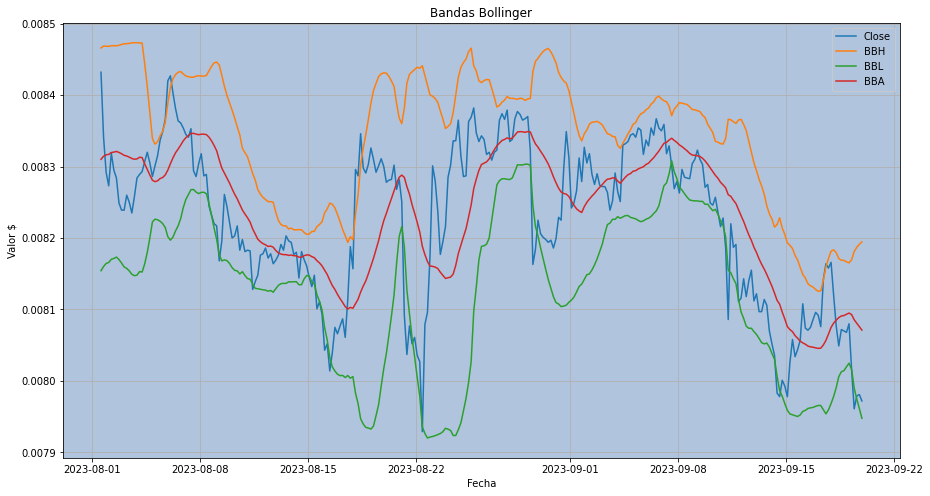

In [49]:
# Graficar las Bandas Bollinger
start_date = '2023-08-01 10:00:00'
df_plot = df[df.index>start_date].copy()

columns = ["Close",'BBH', 'BBL', 'BBA']


plot_line(df_plot,columns,
              figsize=(15, 8),title="Bandas Bollinger")

## MACD

Momentum Indicators 

These indicators measure the strength and rate of change in price movements. They help traders identify potential turning points in the market and can indicate whether an asset is overbought or oversold.

Example: Relative Strength Index (RSI) and MACD
The RSI is a popular momentum oscillator that measures the speed and change of price movements on a scale of 0-100. An RSI reading below 30 typically indicates that an asset is oversold, while a reading above 70 suggests that it is overbought.

The Moving Average Convergence Divergence (MACD) is a momentum indicator. It helps traders identify trend direction, potential trend reversals, and the strength of price movements. The MACD is calculated by subtracting a longer-term Exponential Moving Average (EMA) from a shorter-term EMA, usually the 26-day and 12-day EMAs, respectively. A signal line, typically the 9-day EMA of the MACD, is also plotted on the same chart.

In [51]:
col_use = "Close"
window_slow = 26
window_fast = 12
window_sign = 9
df = put_MACD(df,col_use, window_slow, window_fast, window_sign)
df.columns

Index(['Open_Time', 'Open', 'High', 'Low', 'Close', 'Volumne',
       'Quote_asset_vol', 'Number_trades', 'Taker_buy_base', 'Taker_buy_quote',
       'EMA8', 'EMA13', 'EMA55', 'EMA144', 'Media', 'Desviacion',
       'BandaSuperior', 'BandaInferior', 'Señal', 'BBH_indicator',
       'BBL_indicator', 'BBH', 'BBL', 'BBA', 'MACD_line', 'MACD_signal',
       'MACD_diff'],
      dtype='object')

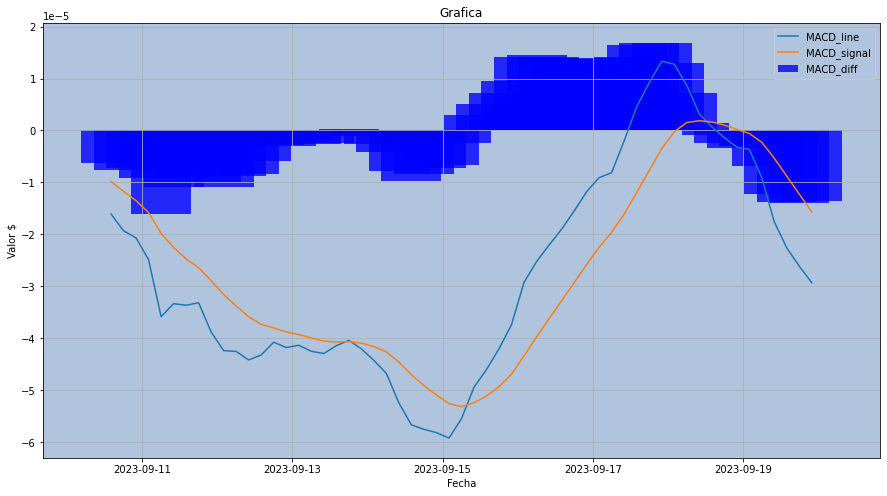

In [52]:
start_date = '2023-09-10 10:00:00'
df_plot = df[df.index>start_date].copy()

columns = ['MACD_line', 'MACD_signal']
to_hist = "MACD_diff"

plot_line(df_plot,columns,
              figsize=(15, 8),title="Grafica", make_hist_MACD=to_hist, alpha=0.8,color='b')

# Ingenieria de caracteristicas
En este punto ya tenemos las columnas (cols_x_corrl) que tienen una fuerte correlacion lineal con nuestra variable a explicar, por lo que necesitamos hacer una transformacion a todas las demas que no tienen esta correlacion lineal para hacer nuestro modelo de regresion mas preciso.

## Volatilidad
Medimos la volatilidad con el coeficiente de variacion que hay en los rendimientos

In [ ]:
import tqdm
from fn_prep import get_volatilidad

In [ ]:
df = df_respaldo.copy()
df.columns

In [ ]:
columns_use = ["Close","Open","High","Low"]
list_statistics = get_volatilidad(df,columns_use)
list_statistics

{'Close': 57.75735300440341,
 'Open': 57.76903980526016,
 'High': 57.660178722706476,
 'Low': 57.87696810551246}

In [ ]:
# Obtener la clave con el valor máximo
clave_maxima = max(list_statistics, key=lambda k: list_statistics[k])
clave_maxima

'Low'

In [ ]:
import time 
simbolos = ['BNBBTC', 'BNBETH', 'BNBUSDT', 'BNBTUSD', 'BNBUSDC', 'BNBBUSD',
       'BNBRUB', 'BNBTRY', 'BNBEUR', 'BNBGBP', 'BNBBIDR', 'BNBDAI',
       'BNBBRL', 'BNBUAH', 'BNBFDUSD']
intervalos = ["1d","12h","8h","6h","4h","2h","1h"]
cols_cv = ["Close","Open","High","Low"]

dict_final = {}
for symbol in tqdm.tqdm(simbolos):
    for interval in intervalos:
        # NOmbre de la tabla
        table_name = symbol+'_'+interval
        
        # cargamos la tabla
        try:
            df_aux = pd.read_sql_query(f'''
                        SELECT *
                        FROM {table_name}
                        ORDER BY Open_Time 
                        ''', con)
            df_aux.Name = table_name
        except:
            print('Fallo al leer ',table_name)
            
        # Generamos la volatilidad
        dict_final[table_name] = get_volatilidad(df_aux,cols_cv)
        time.sleep(1)

In [ ]:
df_vol = pd.DataFrame(dict_final).T
df_vol['Volatilidad_max']  = df_vol.apply(lambda x: max(x[df_vol.columns].values), axis=1)
df_vol['Col_max'] = df_vol.apply(lambda x: max(x[df_vol.columns].values), axis=1).index


In [ ]:
df_vol.loc[[valor for valor in df_vol.index if "_1d" in valor]].sort_values("Volatilidad_max",ascending=False)

In [ ]:
df_vol.loc[[valor for valor in df_vol.index if "_4h" in valor]].sort_values("Volatilidad_max",ascending=False)

In [ ]:
df_vol.loc[[valor for valor in df_vol.index if "_4h" in valor]].sort_values("Volatilidad_max",ascending=False).plot(kind="bar",y=["Volatilidad_max"],)

In [ ]:
n_days_ago = 6
last_day = df_aux['Open_Time'].iloc[-1]
ago = last_day - timedelta(days=n_days_ago)
ago

In [ ]:
df_cp_aux = change_percentual(df_aux[df_aux["Open_Time"]>= ago],"Close",2,get_direction=False)
df_cp_aux[["Close_pc_1", "Close_pc_2"]].mean()

In [ ]:

df_aux.Open_Time.dt.day_name()


## Deteccion de outlayers para la variable explicativa



Puede usar la libreria sklear los metodos:
```python
- from sklearn.ensemble import IsolationForest
```
Crea un modelo Isolation Forest </br>
```python
iso_forest = IsolationForest(contamination=0.05)  # Puedes ajustar el valor de 'contamination' según tus necesidades


- from sklearn.svm import OneClassSVM
```
Crea un modelo One-Class SVM</br>
```python
one_class_svm = OneClassSVM(nu=0.05)  # Puedes ajustar el valor de 'nu' según tus necesidades
```

In [53]:
# Usando la normalizacion  (x-mu)/std
col_use = "Close"
std_tolerancia = 2

df = put_outliers(df,col_use, std_tolerancia)
df['Outliyers_STD'].value_counts()

0.0    8090
1.0      56
Name: Outliyers_STD, dtype: int64

## Cambio percentual y direccion para el n-esimo periodo

In [158]:
from fn_prep import change_percentual
n_period = 2
col_use = "Close"

cols_dir, cols_pc = get_cols_pc_and_dir(n_period,col_use)

df = change_percentual(df,col_use,n_periods=n_period,
                      get_direction=True,all_periods=True)

df[[col_use]+cols_dir+cols_pc]

,Close,Close_dir_1,Close_dir_2,Close_pc_1,Close_pc_2
Close_Time,,,,,
2020-01-01 06:00:00,0.104850,DOWN,DOWN,-0.135615,-0.692410
2020-01-01 10:00:00,0.104708,DOWN,UP,-0.556041,0.145907
2020-01-01 14:00:00,0.104129,UP,UP,0.698067,0.589993
2020-01-01 18:00:00,0.104861,DOWN,DOWN,-0.108834,-0.773622
2020-01-01 22:00:00,0.104747,DOWN,DOWN,-0.664066,-0.640853
...,...,...,...,...,...
2023-09-19 06:00:00,0.132400,DOWN,DOWN,-0.455235,-0.303030
2023-09-19 10:00:00,0.131800,UP,UP,0.151515,0.302572
2023-09-19 14:00:00,0.132000,UP,DOWN,0.151286,-0.075815


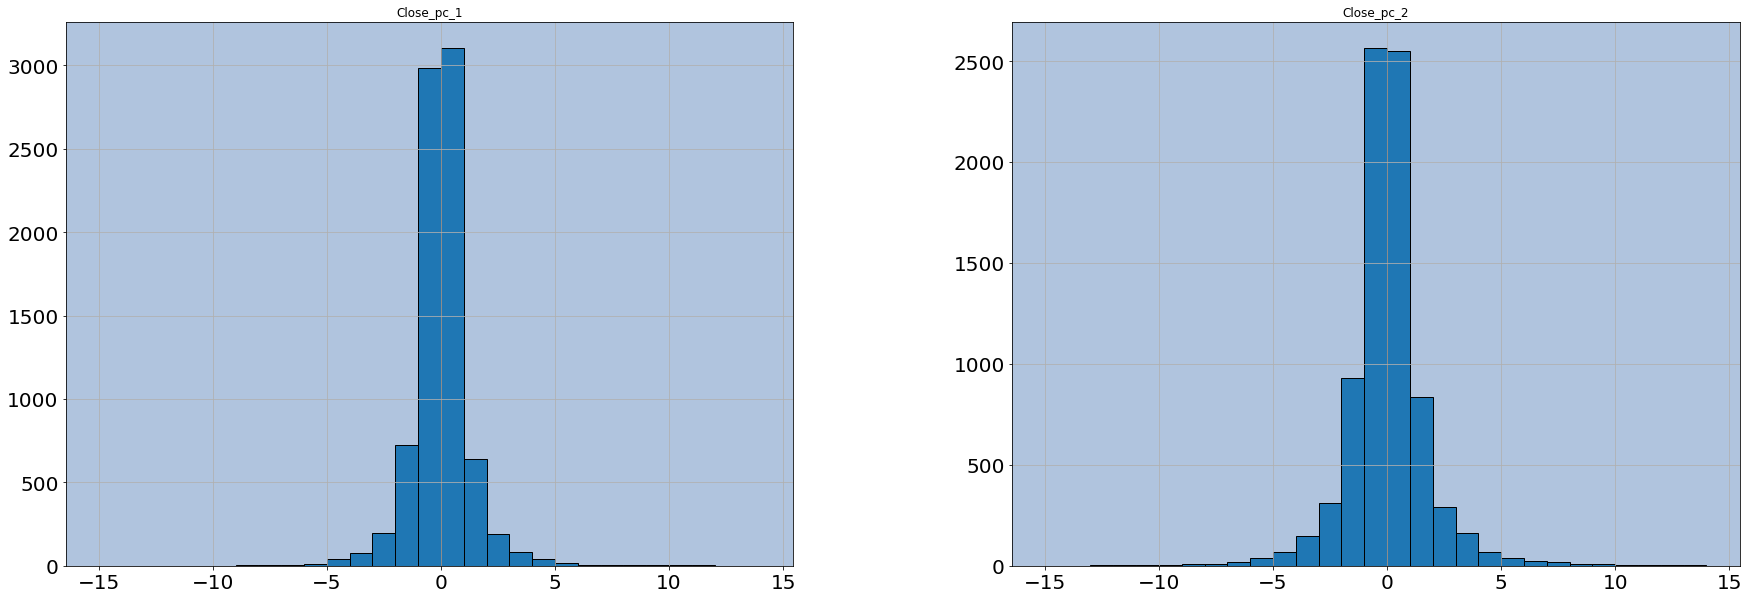

In [55]:

df[cols_pc].hist(bins=range(-15,15), edgecolor='black',
                  figsize=(30,10),
                  xlabelsize=20,ylabelsize=20);

## Prueba de hipotesis para distribucion normal

In [56]:
col_using = "Close_pc_1"
alpha = 0.05
dist="norm" #dist : {'norm', 'expon', 'logistic', 'gumbel', 'gumbel_l', 'gumbel_r', 'extreme1'}

data = np.random.normal(0, 1, 1000)
prueba_hipotesis(df,col_using, alpha, dist = 'norm', get_data=False)



+--------------------+-------------------------+-------------+-----------------------+
| Prueba             |   Estadístico de Prueba |     Valor P | Veredicto             |
+====================+=========================+=============+=======================+
| Anderson-Darling   |             291.705     | 0.787       | No sigue distribucion |
+--------------------+-------------------------+-------------+-----------------------+
| Shapiro-Wilk       |               0.826346  | 0           | No sigue distribucion |
+--------------------+-------------------------+-------------+-----------------------+
| Kolmogorov-Smirnov |               0.0709051 | 4.71516e-36 | No sigue distribucion |
+--------------------+-------------------------+-------------+-----------------------+


In [57]:
kk = [1,2,1,2,1,2,1,2]
kk, set(kk)

([1, 2, 1, 2, 1, 2, 1, 2], {1, 2})

## Correlacion con la variable explicativa vs variables x

In [58]:
df.columns

Index(['Open_Time', 'Open', 'High', 'Low', 'Close', 'Volumne',
       'Quote_asset_vol', 'Number_trades', 'Taker_buy_base', 'Taker_buy_quote',
       'EMA8', 'EMA13', 'EMA55', 'EMA144', 'Media', 'Desviacion',
       'BandaSuperior', 'BandaInferior', 'Señal', 'BBH_indicator',
       'BBL_indicator', 'BBH', 'BBL', 'BBA', 'MACD_line', 'MACD_signal',
       'MACD_diff', 'Outliyers_STD', 'Close_pc_1', 'Close_pc_2', 'Close_dir_1',
       'Close_dir_2'],
      dtype='object')

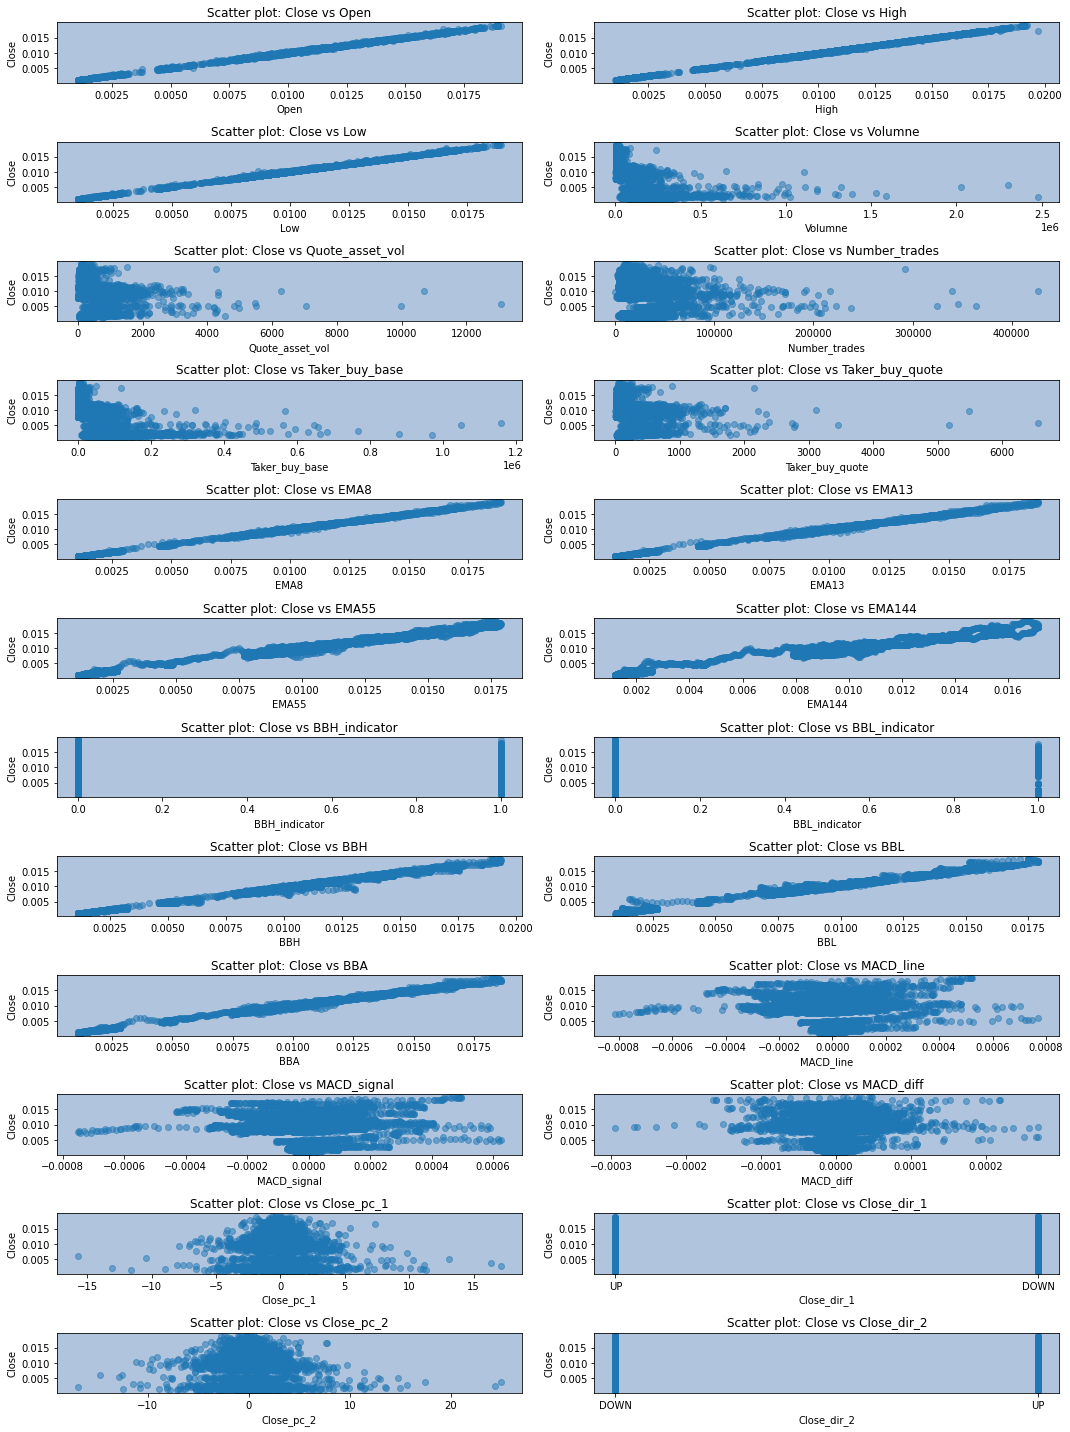

In [59]:
cols_x = ['Open', 'High', 'Low','Volumne','Quote_asset_vol', 'Number_trades', 'Taker_buy_base', 'Taker_buy_quote',
          'EMA8', 'EMA13', 'EMA55', 'EMA144', 'BBH_indicator', 'BBL_indicator',
       'BBH', 'BBL', 'BBA', 'MACD_line', 'MACD_signal', 'MACD_diff',
       'Close_pc_1', 'Close_dir_1', 'Close_pc_2', 'Close_dir_2']
col_y = 'Close'
plot_scatter(df,cols_x,col_y)

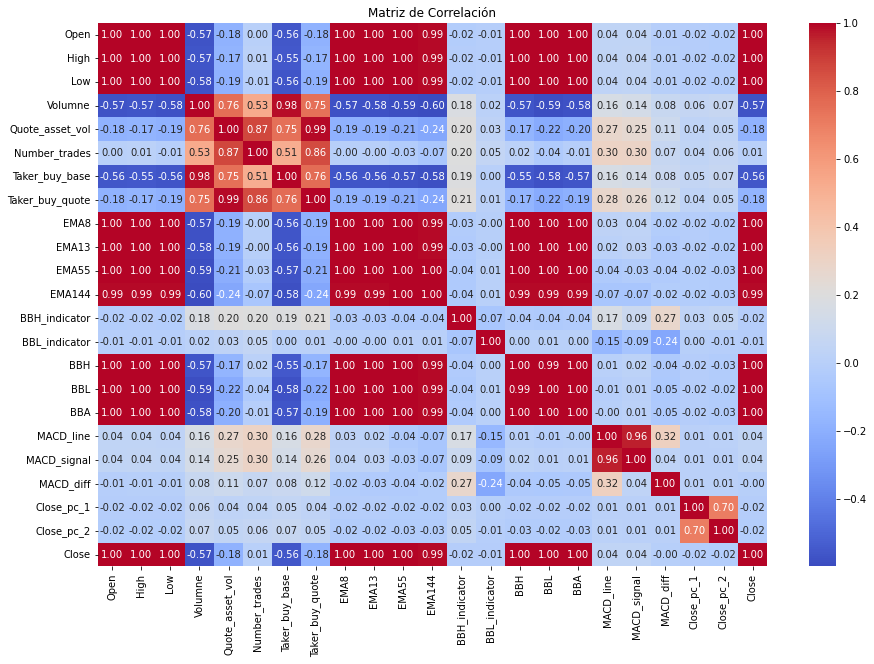

array(['Open', 'High', 'Low', 'EMA8', 'EMA13', 'EMA55', 'EMA144', 'BBH',
       'BBL', 'BBA'], dtype=object)

In [60]:
# Lista de columnas a incluir en el gráfico de correlación
cols_x = ['Open', 'High', 'Low','Volumne','Quote_asset_vol', 'Number_trades', 'Taker_buy_base', 'Taker_buy_quote',
          'EMA8', 'EMA13', 'EMA55', 'EMA144', 'BBH_indicator', 'BBL_indicator',
       'BBH', 'BBL', 'BBA', 'MACD_line', 'MACD_signal', 'MACD_diff',
       'Close_pc_1', 'Close_dir_1', 'Close_pc_2', 'Close_dir_2']
col_y = "Close"
cols_x_corrl = plot_correlation(df,cols_x,col_y,min_corr=0.8,figsize=(15,10))
cols_x_corrl

## Lag n-esimo
En las series de tiempo es usual decir que el valor actual de y<sub>n</sub>, depende del valor anterior y<sub>n-1</sub> incluso podemos decir que depende de los ultimos k-periodos. Por lo que la ecuacion seria:

  Y<sub>n</sub> = B<sub>0</sub> + B<sub>1</sub>*y<sub>n-1</sub> + B<sub>2</sub>*y<sub>n-2</sub> + ... + B<sub>k</sub>*y<sub>n-k</sub> + u

In [62]:
col_use = "Close_pc_1"
periodos_lag = 4
cols_lag = []
for i in range(1,periodos_lag+1):
    cols_lag.append(col_use+"_lag_"+str(i))
    df[col_use+"_lag_"+str(i)] = df[col_use].shift(i)
    
df.columns


Index(['Open_Time', 'Open', 'High', 'Low', 'Close', 'Volumne',
       'Quote_asset_vol', 'Number_trades', 'Taker_buy_base', 'Taker_buy_quote',
       'EMA8', 'EMA13', 'EMA55', 'EMA144', 'Media', 'Desviacion',
       'BandaSuperior', 'BandaInferior', 'Señal', 'BBH_indicator',
       'BBL_indicator', 'BBH', 'BBL', 'BBA', 'MACD_line', 'MACD_signal',
       'MACD_diff', 'Outliyers_STD', 'Close_pc_1', 'Close_pc_2', 'Close_dir_1',
       'Close_dir_2', 'Close_pc_1_lag_1', 'Close_pc_1_lag_2',
       'Close_pc_1_lag_3', 'Close_pc_1_lag_4'],
      dtype='object')

In [63]:
df[cols_lag+[col_use]]

,Close_pc_1_lag_1,Close_pc_1_lag_2,Close_pc_1_lag_3,Close_pc_1_lag_4,Close_pc_1
Close_Time,,,,,
2020-01-01 06:00:00,NaN,NaN,NaN,NaN,0.251204
2020-01-01 10:00:00,0.251204,NaN,NaN,NaN,-0.674394
2020-01-01 14:00:00,-0.674394,0.251204,NaN,NaN,0.288941
2020-01-01 18:00:00,0.288941,-0.674394,0.251204,NaN,-0.326780
2020-01-01 22:00:00,-0.326780,0.288941,-0.674394,0.251204,-0.375622
...,...,...,...,...,...
2023-09-19 06:00:00,-0.810979,0.148515,-0.024789,-0.024783,-0.678307
2023-09-19 10:00:00,-0.678307,-0.810979,0.148515,-0.024789,0.225592
2023-09-19 14:00:00,0.225592,-0.678307,-0.810979,0.148515,0.025060


## Particionado de datos.

In [ ]:
df.shape

(8146, 27)

In [166]:
# Quitar nan, debido a los calculos de EMA, MACD, BB, Lag, etc hay nans
print ("Shape original ", df.shape)
df_train = df.dropna(how="any")
df_train.rename(columns={'Volumne':'Volume'},inplace=True)
df_train.shape

Shape original  (8146, 14)


(8144, 14)

In [167]:
# Dividir df en X y Y

## Columna usada para el cambio percentual y direccion
col_use = "Close"
## En caso de querer y multiclase hacer True
incluir_todos_periodos = False 
## Si no incluye todos los periodos con cual se queda
ind = 1 
## Para incluir el ultimo precio en los datos
incluir_ultimo = True
## Solo funciona 
predecir = "_dir"  # _dir, _pc
## En caso de ser clasificacion
is_classification = True

all_columns = list(df_train.columns)
if incluir_todos_periodos:
    if predecir == "_pc":
        col_y = [valor for valor in df.columns if "_pc" in valor]
        
        
    elif predecir == "_dir":
        col_y = [valor for valor in df.columns if "_dir" in valor]
        cols_x = all_columns.copy()
        for col in col_y:
            cols_x.remove(col)
        
else:
    if predecir == "_pc":
        col_y = col_use+"_pc_"+str(ind)
        cols_x = all_columns.copy()
        cols_x.remove(col_y)
        
    
    elif predecir == "_dir":
        col_y = col_use+"_dir_"+str(ind)
        cols_x = all_columns.copy()
        cols_x.remove(col_y)
        
        



#cols_x = cols_x_corrl.copy()
'''
cols_x = ['Open', 'High', 'Low','Volume','Quote_asset_vol', 'Number_trades', 'Taker_buy_base', 'Taker_buy_quote',
          'EMA8', 'EMA13', 'EMA55', 'EMA144', 'BBH_indicator', 'BBL_indicator',
       'BBH', 'BBL', 'BBA', 'MACD_line', 'MACD_signal', 'MACD_diff',
        'Close_dir_1', 'Close_dir_2'] # 'Close_pc_1', 'Close_pc_2'
'''
if not incluir_ultimo:
    X = df_train[cols_x].iloc[:-1].copy()
    y = df_train[col_y].iloc[:-1].copy()
    X_last = df_train[cols_x].iloc[-1:, :].copy()
    y_last = df_train[col_y].iloc[-1:].copy()
else:
    y = df_train[col_y].copy()
    X = df_train[cols_x].copy()
    
if is_classification:
    y = y.map({"UP":1,"DOWN":0})
#
#X_last = df[cols_x].iloc[-1:, :].copy()



In [168]:
# Revisamos que todas las columnas sean numericas
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8144 entries, 2020-01-01 06:00:00 to 2023-09-19 14:00:00
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Open_Time        8144 non-null   datetime64[ns]
 1   Open             8144 non-null   float64       
 2   High             8144 non-null   float64       
 3   Low              8144 non-null   float64       
 4   Close            8144 non-null   float64       
 5   Volume           8144 non-null   float64       
 6   Quote_asset_vol  8144 non-null   float64       
 7   Number_trades    8144 non-null   int64         
 8   Taker_buy_base   8144 non-null   float64       
 9   Taker_buy_quote  8144 non-null   float64       
 10  Close_pc_1       8144 non-null   float64       
 11  Close_pc_2       8144 non-null   float64       
 12  Close_dir_2      8144 non-null   object        
dtypes: datetime64[ns](1), float64(10), int64(1), object(1)
me

In [68]:
X.Close_dir_1 = X.Close_dir_1.map({'UP':1,'DOWN':0})

In [69]:
X.Close_dir_2 = X.Close_dir_2.map({'UP':1,'DOWN':0})

In [169]:
X.columns, y.name

(Index(['Open_Time', 'Open', 'High', 'Low', 'Close', 'Volume',
        'Quote_asset_vol', 'Number_trades', 'Taker_buy_base', 'Taker_buy_quote',
        'Close_pc_1', 'Close_pc_2', 'Close_dir_2'],
       dtype='object'),
 'Close_dir_1')

In [170]:
n = X.shape[0]
train_size = .8

x_train, x_test = X.iloc[:int(n*train_size)].copy(), X.iloc[int(n*train_size):].copy()
yy_train, yy_test = y.iloc[:int(n*train_size)].copy(), y.iloc[int(n*train_size):].copy()
print(x_train.shape[0]+ x_test.shape[0]==df_train.shape[0])
x_train.shape, x_test.shape

True


((6515, 13), (1629, 13))

## Modelos de clasificacion

Funciones de score: 

| Scoring | Function | Comment|
| --- | ---: | :---: |
|Classification |  |  |
| ‘accuracy’ | metrics.accuracy_score| |
| ‘balanced_accuracy’| metrics.balanced_accuracy_score | |
| ‘top_k_accuracy’ | metrics.top_k_accuracy_score | |
| ‘average_precision’ | metrics.average_precision_score | |
| ‘neg_brier_score’ | metrics.brier_score_loss | |
| ‘f1’ | metrics.f1_score | for binary targets |
| ‘f1_micro’ | metrics.f1_score | micro-averaged |
| ‘f1_macro’ | metrics.f1_score | macro-averaged |
| ‘f1_weighted’ | metrics.f1_score |weighted average |
| ‘f1_samples’ | metrics.f1_score | by multilabel sample|
| ‘neg_log_loss’ | metrics.log_loss | requires predict_proba support |
| ‘precision’ etc. | metrics.precision_score |suffixes apply as with ‘f1’ |
| ‘recall’ etc. | metrics.recall_score | suffixes apply as with ‘f1’ |
| ‘jaccard’ etc. | metrics.jaccard_score | suffixes apply as with ‘f1’ |
| ‘roc_auc’ | metrics.roc_auc_score | |
| ‘roc_auc_ovr’ | metrics.roc_auc_score | |
| ‘roc_auc_ovo’ | metrics.roc_auc_score | |
| ‘roc_auc_ovr_weighted’ | metrics.roc_auc_score | |
| ‘roc_auc_ovo_weighted’ | metrics.roc_auc_score | |

In [81]:
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
ts = TimeSeriesSplit(test_size=200)

In [179]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score, roc_auc_score, f1_score








In [ ]:
# Modelo RandomForestClassifier
# Muy pesado, no util para [UP, DOWN]
n_estimators = [50,100, 200, 300], # Cantidad de arboles
max_depth = [ 10, 20,30,50],
min_samples_split = [2, 5, 10], # Cantidad de muestras para dividir un nodo
min_samples_leaf = [1, 2, 4,10],   # Cantidad de muestras para dividir una hoja
max_features =  ['auto', 'sqrt']

error_mse_list = []
accuracy_list = [0]
model_chido = None

besth_depth = []
best_estimator = []
best_split = []
best_leaf = []
best_feature = []
best_acuracy = []
best_score = []


for estimator in [50,100, 200, 300]:
    for depth1 in [ 10, 20,30,50]:
        for split in [2, 5, 10]:
            for leaf in [1, 2, 4,10]:
                for feature in ['log2', 'sqrt']:
                    model = RandomForestClassifier(n_estimators=estimator,
                                                   max_depth=depth1,
                                                   min_samples_split=split,
                                                   min_samples_leaf=leaf,
                                                   max_features=feature)
                    for index_train, index_test in ts.split(X_test.iloc[:-1,:]):
                        X_train, y_train = X.iloc[index_train], y.iloc[index_train]
                        X_test, y_test = X.iloc[index_test], y.iloc[index_test]
                        
                        model.fit(X_train, y_train)
                        
                        y_pred = model.predict(X_test)
                        
                        #error_mse = mean_squared_error(y_test, y_pred)
                        #error_mse_list.append(error_mse)
                        #print(f'El MSE es: {error_mse}')
                        
                        acuracy = accuracy_score(y_test, y_pred)
                        
                        #print(f'El acuracy es: {acuracy}')
                        #print(acuracy > max(accuracy_list))
                        
                        if acuracy > max(accuracy_list):
                            
                            score = model.score(X_train, y_train)
                            print(f'El acuracy es: {acuracy}')
                            print(f'Score del modelo: {score}')
                            model_chido = model
                            besth_depth.append(depth1)
                            best_estimator.append(estimator)
                            best_split.append(split)
                            best_leaf.append(leaf)
                            best_feature.append(feature)
                            best_acuracy.append(acuracy)
                            best_score.append(score)
                            
                            # Calcular la matriz de confusión
                            clases = model.classes_
                            matriz_confusion = confusion_matrix(y, y_pred,labels=clases)
                            show_matriz_confusion(matriz_confusion)
                            
                        accuracy_list.append(acuracy)
                        
                        best_estimator = np.array(best_estimator)*0
accuracy_list.remove(0)
df_aux = pd.DataFrame({'Depth':besth_depth,
                        'Estimator':best_estimator,
                        'Split': best_split,
                        'Leaf':best_leaf,
                        'Feature':best_feature,
                        'Accuracy':best_acuracy})
df_parameters = pd.concat([df_parameters,df_aux])

print('RESULTADOS'.center(100,'-'))
print('Se obtuvo en un pormedio de ',np.mean(accuracy_list),' en el accuracy')
print('Cuya desvicion estandar fue de: ',np.std(accuracy_list))
# (mean, n) = (0.5021733472149922, 1921)

In [ ]:
# Modelo DecisionTreeClassifier


def train_DecisionTreeClassifier(X,y,ts,df_parameters=pd.DataFrame(),show_hist=True):
    import numpy as np
    accuracy_list = [0]
    model_chido = None
    besth_depth = []
    best_split = []
    best_leaf = []
    best_feature = []
    best_acuracy = []
    best_score = []
    dict_best_parameters = {}
    df_split = X.copy()



    for depth1 in [ 10, 20,30,50,80]:
        for split in [2, 5, 10]:
            for leaf in [1, 3, 7,10]:
                for feature in ['log2', 'sqrt']:
                    # Invocamos al modelo
                    model = DecisionTreeClassifier(
                                                    max_depth=depth1,
                                                    min_samples_split=split,
                                                    min_samples_leaf=leaf,
                                                    max_features=feature)
                    
                    # Entrenamos con particion de TimeSeriesSplit
                    for index_train, index_test in ts.split(df_split):
                        X_train, y_train = X.iloc[index_train], y.iloc[index_train]
                        X_test, y_test = X.iloc[index_test], y.iloc[index_test]
                        
                        model.fit(X_train, y_train)
                        
                        y_pred = model.predict(X_test)
                        
                        #error_mse = mean_squared_error(y_test, y_pred)
                        #error_mse_list.append(error_mse)
                        #print(f'El MSE es: {error_mse}')
                        
                        acuracy = accuracy_score(y_test, y_pred)
                        
                        #print(f'El acuracy es: {acuracy}')
                        #print(acuracy > max(accuracy_list))
                        
                        if acuracy > max(accuracy_list):
                            score = model.score(X_train, y_train)
                            print(f'El acuracy es: {acuracy}')
                            print(f'Score del modelo: {score}')
                            
                            # Cremos diccionario
                            dict_best_parameters["max_depth"] = depth1
                            dict_best_parameters["min_samples_split"] = split
                            dict_best_parameters["min_samples_leaf"] = split
                            dict_best_parameters["max_features"] = split
                            
                            model_chido = model
                            besth_depth.append(depth1)
                            best_split.append(split)
                            best_leaf.append(leaf)
                            best_feature.append(feature)
                            best_acuracy.append(acuracy)
                            best_score.append(score)
                            
                            # Calcular la matriz de confusión
                            clases = model.classes_
                            matriz_confusion = confusion_matrix(y_test, y_pred,labels=clases)
                            show_matriz_confusion(matriz_confusion)
                            
                            
                        accuracy_list.append(acuracy)
                        if acuracy ==1: break

    accuracy_list.remove(0)
    df_aux = pd.DataFrame({'Depth':besth_depth,
                            'Split': best_split,
                            'Leaf':best_leaf,
                            'Feature':best_feature,
                            'Accuracy':best_acuracy})
    df_parameters = pd.concat([df_parameters,df_aux])

    print('RESULTADOS'.center(100,'-'))
    print('Se obtuvo en un promedio de ',np.mean(accuracy_list),' en el accuracy')
    print('Cuya desvicion estandar fue de: ',np.std(accuracy_list))

    if show_hist:
        import numpy as np 
        import matplotlib.pyplot as plt

        print(f'Se hicieron {len(accuracy_list)} pruebas \nel accuracy medio fue: {np.mean(accuracy_list)}')


        plt.hist(accuracy_list,bins=10,edgecolor='black')
        plt.title("Histograma de accuracy")
        plt.show()
    return model_chido, df_parameters, dict_best_parameters


In [108]:
x_train.columns

Index(['Open_Time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Quote_asset_vol', 'Number_trades', 'Taker_buy_base', 'Taker_buy_quote',
       'EMA8', 'EMA13', 'EMA55', 'EMA144', 'Media', 'Desviacion',
       'BandaSuperior', 'BandaInferior', 'Señal', 'BBH_indicator',
       'BBL_indicator', 'BBH', 'BBL', 'BBA', 'MACD_line', 'MACD_signal',
       'MACD_diff', 'Outliyers_STD', 'Close_pc_1', 'Close_pc_2', 'Close_dir_2',
       'Close_pc_1_lag_1', 'Close_pc_1_lag_2', 'Close_pc_1_lag_3',
       'Close_pc_1_lag_4'],
      dtype='object')

In [174]:
# Usando optimizador GridSearchCV

# Definir el rango de valores para cada parámetro
param_grid = {
   # 'n_estimators': [50,100, 200, 300], # Cantidad de arboles
    'max_depth': [ 10, 20,30,50],
    'min_samples_split': [2, 5, 10], # Cantidad de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4,10],   # Cantidad de muestras para dividir una hoja
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy', 'log_loss']
}
scoring = 'accuracy'

cols_train = ['Open', 'High', 'Low', 'Volume', 'Quote_asset_vol', 'Number_trades',
       'Taker_buy_base', 'Taker_buy_quote',"Close_pc_1"]

model = DecisionTreeClassifier(random_state=42)

gs = grid_search(x_train[cols_train],yy_train,model,param_grid,cv=ts,verbose=1,scoring=scoring,return_train_score=False)

# Evaluar el modelo final en los datos de prueba
model_chido = gs.best_estimator_
accuracy = model_chido.score(x_test[cols_train], yy_test)
print("Accuracy en los datos de prueba:", accuracy)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Mejores parámetros: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
Mejor puntaje: 0.99
Accuracy en los datos de prueba: 1.0


In [180]:
# Ultimo modelo entrenado
y_pred = model_chido.predict(x_test[cols_train])
get_scores_clasification(yy_test, y_pred,table_name)

************************ BNBETH_4h *************************
+-------------------+---------+---------+
| Score Fn          |   Value | Ideal   |
+===================+=========+=========+
| Accuracy          |       1 | -> 1    |
+-------------------+---------+---------+
| Average precision |       1 | -> 1    |
+-------------------+---------+---------+
| Roc Auc           |       1 | -> 1    |
+-------------------+---------+---------+
| F1                |       1 | -> 1    |
+-------------------+---------+---------+


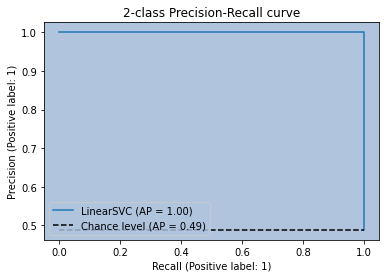

In [127]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(
    yy_test.map({"UP":1,"DOWN":0}), y_pred, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [145]:
yy_test.value_counts()

0    819
1    782
Name: Close_dir_1, dtype: int64

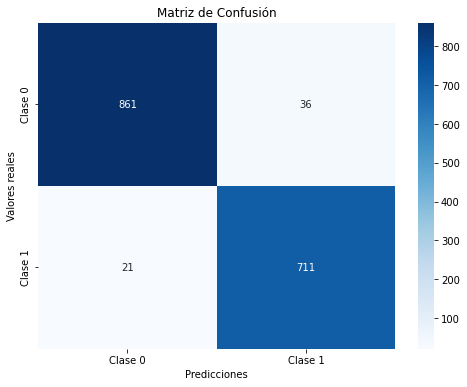

In [172]:
matriz_confusion = confusion_matrix(yy_test, y_pred,labels=model_chido.classes_)
show_matriz_confusion(matriz_confusion)

In [148]:
table_name, datetime.now().strftime("%m-%Y")

('BNBBTC_4h', '09-2023')

In [181]:
# Guardar_modelo
import pickle
name_model = "DecisionTreeClassifier_"+table_name
with open(f'Models/{name_model}.pkl', 'wb') as f:
    pickle.dump(model_chido, f)

In [177]:
# Leer el modelo
import pickle
from sklearn.metrics import accuracy_score
with open(f'Models/{name_model}.pkl', 'rb') as f:
    model_chido1 = pickle.load(f)
    
# Ultimo modelo entrenado
get_scores_clasification(yy_test, model_chido1.predict(x_test[cols_train]),table_name=table_name)

FileNotFoundError: [Errno 2] No such file or directory: 'Models/DecisionTreeClassifier_BNBBTC_4h_09-2023.pkl'

## Modelos de regresion

Aqui te dejo una lista de los scoring que se usan en la regresion

| Scoring | Function | Comment|
| --- | ---: | :---: |
|Regresion |  |  |
| ‘explained_variance’ | metrics.explained_variance_score | |
| ‘max_error’ | metrics.max_error | |
| ‘neg_mean_absolute_error’ | metrics.mean_absolute_error | |
| ‘neg_mean_squared_error’ | metrics.mean_squared_error | |
| ‘neg_root_mean_squared_error’ | metrics.mean_squared_error | |
| ‘neg_mean_squared_log_error’ | metrics.mean_squared_log_error | |
| ‘neg_median_absolute_error’ | metrics.median_absolute_error | |
| ‘r2’ | metrics.r2_score | |
| ‘neg_mean_poisson_deviance’ | metrics.mean_poisson_deviance | |
| ‘neg_mean_gamma_deviance’ | metrics.mean_gamma_deviance | |
| ‘neg_mean_absolute_percentage_error’ | metrics.mean_absolute_percentage_error | |
| ‘d2_absolute_error_score’ | metrics.d2_absolute_error_score | |
| ‘d2_pinball_score’ | metrics.d2_pinball_score | |
| ‘d2_tweedie_score’ | metrics.d2_tweedie_score | |


### Verificacion de supuestos (Gauss-Markov)

- Supuesto 1 del MRLS: Linealidad de los parámetros
- Supuesto 2 del MRLS: Muestreo aleatorio
- Supuesto 3 del MRLS: Variación muestral de la variable explicativa
- Supuesto 4 del MRLS: Media condicional cero

In [74]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score

def get_scores_regresion(y_true, y_pred):
    table = []
    table.append(["R2",r2_score(y_true,y_pred), "-> 1"])
    table.append(["Absolute error", mean_absolute_error(y_true, y_pred), "-> 0"])
    table.append(["Squared error", mean_squared_error(y_true, y_pred), "-> 0"])
    table.append(["Explained variance", explained_variance_score(y_true, y_pred), " -> 1"])
    
    headers = ["Score Fn", "Value","Ideal"]
    table_str = tabulate(table, headers, tablefmt='grid')

    print(table_str)

In [73]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import numpy as np

### Bayesian Regression¶
* Las ventajas de la regresión bayesiana son:

Se adapta a los datos disponibles.

Se puede utilizar para incluir parámetros de regularización en el procedimiento de estimación.

* Las desventajas de la regresión bayesiana incluyen:

La inferencia del modelo puede llevar mucho tiempo.

In [ ]:
from sklearn.linear_model import BayesianRidge


def entrenar_bayesian_ridge(x_train, y_train, hiperparametros,ts):
    """
    Entrena un modelo BayesianRidge utilizando búsqueda en cuadrícula (grid search) con diferentes hiperparámetros.

    Parameters:
    - x_train: Datos de entrenamiento (numpy array o similar).
    - y_train: Etiquetas de entrenamiento (numpy array o similar).
    - hiperparametros: Diccionario de hiperparámetros a probar.

    Returns:
    - Mejor modelo BayesianRidge encontrado.
    """

    # Crear el modelo BayesianRidge
    modelo = BayesianRidge()

    # Crear el objeto GridSearchCV para búsqueda en cuadrícula
    grid_search = GridSearchCV(modelo, hiperparametros, cv=ts, scoring=('neg_mean_squared_error'))

    # Entrenar el modelo con diferentes hiperparámetros
    grid_search.fit(x_train, y_train)

    # Devolver el mejor modelo encontrado
    mejor_modelo = grid_search.best_estimator_

    return mejor_modelo

# Ejemplo de uso:
def train_BayesianRidge(x_train,y_train,ts):
    # Datos de entrenamiento de ejemplo

    # Hiperparámetros a probar (ejemplo)
    hiperparametros = {
        'alpha_1':  [1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e-0],
        'alpha_2':  [1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e-0],
        'lambda_1': [1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e-0],
        'lambda_2': [1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e-0],
        'tol': [0.001,0.01,0.1,1]
    }

    # Entrenar el modelo BayesianRidge con búsqueda en cuadrícula
    mejor_modelo = entrenar_bayesian_ridge(x_train, y_train, hiperparametros,ts)

    # Imprimir los hiperparámetros del mejor modelo encontrado
    print("Mejores hiperparámetros:")
    print(mejor_modelo.get_params())
    print('Score', mejor_modelo.scores_)
    return mejor_modelo, mejor_modelo.get_params()


In [ ]:
model.score(x_train,yy_train)

0.38406808714597873

In [ ]:
ts = TimeSeriesSplit(test_size=200)
model,params = train_BayesianRidge(x_train,yy_train,ts)

Mejores hiperparámetros:
{'alpha_1': 1.0, 'alpha_2': 1e-06, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1.0, 'lambda_init': None, 'max_iter': None, 'n_iter': 'deprecated', 'tol': 0.001, 'verbose': False}
Score []


In [ ]:
modelo = BayesianRidge(**params)
modelo.fit(x_train,yy_train)

BayesianRidge(alpha_1=1.0, lambda_2=1.0)

In [ ]:
modelo.score(x_train,yy_train)

0.38406808714597873

Conclusion 20/09/23 es muy tardado y poco eficiente
el maxim score obtenido es de 0.38406808714597873 tardando 12 min cuyos parametros fueron:

{'alpha_1': 1.0, 'alpha_2': 1e-06, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1.0, 'lambda_init': None, 'max_iter': None, 'n_iter': 'deprecated', 'tol': 0.001, 'verbose': False}

### Arbol de regresion

In [71]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

def entrenar_decision_tree(x_train, y_train, hiperparametros,ts):
    """
    Entrena un modelo DecisionTreeRegressor utilizando búsqueda en cuadrícula (grid search) con diferentes hiperparámetros.

    Parameters:
    - x_train: Datos de entrenamiento (numpy array o similar).
    - y_train: Etiquetas de entrenamiento (numpy array o similar).
    - hiperparametros: Diccionario de hiperparámetros a probar.

    Returns:
    - Mejor modelo DecisionTreeRegressor encontrado.
    """

    # Crear el modelo DecisionTreeRegressor
    modelo = DecisionTreeRegressor()

    # Crear el objeto GridSearchCV para búsqueda en cuadrícula
    grid_search = GridSearchCV(modelo, hiperparametros, cv=ts, scoring='neg_mean_squared_error')

    # Entrenar el modelo con diferentes hiperparámetros
    grid_search.fit(x_train, y_train)

    # Devolver el mejor modelo encontrado
    mejor_modelo = grid_search.best_estimator_

    # Obtener los resultados de la búsqueda en cuadrícula
    resultados = grid_search.cv_results_
   

    # Graficar los puntajes en función de los hiperparámetros
    #graficar_resultados(resultados, hiperparametros)

    return mejor_modelo


# Ejemplo de uso:
def train_DecisionTreeRegresor(x_train,y_train,ts):
    # Datos de entrenamiento de ejemplo
    #x_train = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])
    #y_train = np.array([1, 2, 3, 4])

    # Hiperparámetros a probar (ejemplo)
    hiperparametros = {
        'max_depth': [None,3, 5, 10, 15,30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        #"criterion":["squared_error", "friedman_mse", "absolute_error", "poisson"],
        "splitter": ["best", "random"],
        #"max_features":["auto", "sqrt", "log2"],
        #"max_leaf_nodes":[2,5,10],
        #"min_weight_fraction_leaf":[0,0.01,0.1,0.3]
    }

    # Entrenar el modelo DecisionTreeRegressor con búsqueda en cuadrícula y visualizar los gráficos
    mejor_modelo = entrenar_decision_tree(x_train, y_train, hiperparametros,ts)

    # Imprimir los hiperparámetros del mejor modelo encontrado
    print("Mejores hiperparámetros:")
    print(mejor_modelo.get_params())
    return mejor_modelo, mejor_modelo.get_params()


In [77]:
ts = TimeSeriesSplit(test_size=100)
model, params = train_DecisionTreeRegresor(x_train,yy_train,ts)

Mejores hiperparámetros:
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [78]:
model.score(x_train,yy_train)

0.5661582840091872

In [79]:
get_scores_regresion(yy_train,model.predict(x_train))

+--------------------+----------+---------+
| Score Fn           |    Value | Ideal   |
+====================+==========+=========+
| R2                 | 0.566158 | -> 1    |
+--------------------+----------+---------+
| Absolute error     | 0.599831 | -> 0    |
+--------------------+----------+---------+
| Squared error      | 0.92446  | -> 0    |
+--------------------+----------+---------+
| Explained variance | 0.566158 | -> 1    |
+--------------------+----------+---------+


In [80]:
get_scores_regresion(yy_test,model.predict(x_test))

+--------------------+----------+---------+
| Score Fn           |    Value | Ideal   |
+====================+==========+=========+
| R2                 | 0.407724 | -> 1    |
+--------------------+----------+---------+
| Absolute error     | 0.394703 | -> 0    |
+--------------------+----------+---------+
| Squared error      | 0.327907 | -> 0    |
+--------------------+----------+---------+
| Explained variance | 0.408755 | -> 1    |
+--------------------+----------+---------+


Conclusion

score: 042 parametros: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}

score: 0.39 time: 9m parametros: {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

score: 0.46, time:13.2, parametros: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

score: 0.50, time 7m, parametros: {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

score: 0.44, time: 11m, parametros: {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

score: 0.42, time: 81m, parametros: {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.01, 'random_state': None, 'splitter': 'best'}

score: 0.56, time: 39s, parametros: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

### Regresion Lineal

Ordinary least squares Linear Regression.

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6516 entries, 2020-01-01 06:00:00 to 2022-12-22 06:00:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6516 non-null   float64
 1   High    6516 non-null   float64
 2   Low     6516 non-null   float64
 3   EMA8    6509 non-null   float64
 4   EMA13   6504 non-null   float64
 5   EMA55   6462 non-null   float64
 6   EMA144  6373 non-null   float64
 7   BBH     6497 non-null   float64
 8   BBL     6497 non-null   float64
 9   BBA     6497 non-null   float64
dtypes: float64(10)
memory usage: 560.0 KB


In [ ]:
from sklearn.linear_model import LinearRegression
ts = TimeSeriesSplit(test_size=100)

model = LinearRegression(fit_intercept=True)
model.fit(x_train, yy_train)
model.score(x_train, yy_train)

0.41249552261057054

In [ ]:
get_scores_regresion(yy_train,model.predict(x_train))

+--------------------+----------+
| Score Fn           |    Value |
+====================+==========+
| R2                 | 0.412496 |
+--------------------+----------+
| Absolute error     | 0.682427 |
+--------------------+----------+
| Squared error      | 1.2519   |
+--------------------+----------+
| Explained variance | 0.412496 |
+--------------------+----------+


## Backtesting

### Sobre clasificacion

In [ ]:
# Leer el modelo
import pickle
from sklearn.metrics import accuracy_score
with open('Models/DecisionTreeClassifier.pkl', 'rb') as f:
    model_chido = pickle.load(f)

print('Acuracy del modelo sobre set de testeo: ',accuracy_score(yy_test, model_dt.predict(x_test)))

In [ ]:
df.Name

In [ ]:
print(accuracy)

In [ ]:
# Bactesting
from backtesting import Strategy, Backtest

class ClassificationUP(Strategy):
    def init(self):
        # Instanciamos el modelo
        self.model = model_dt  #model_chido, best_model
        # Indicadora sobre si ya hemos comprado
        self.already_bought = False

    def next(self):
        # Variable global de Strategy data.df
        #print(self.data.df.columns)
        explanatory_today = self.data.df.iloc[-1:, :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]

        # conditions to sell or buy

        ## Buy
        if forecast_tomorrow == 'UP' and self.already_bought == False:
            self.buy()
            self.already_bought = True

        ## Sell
        elif forecast_tomorrow == 'DOWN' and self.already_bought == True:
            self.sell()
            self.already_bought = False

        ## Nothing
        else: pass
        
        
bt = Backtest(data=X.iloc[:-1], strategy=ClassificationUP,
              cash=20000, commission=.002, exclusive_orders=True)
results = bt.run()
results.to_frame(name='Values').loc[:'Avg. Trade Duration']

In [ ]:
X_test.loc[ind]

In [ ]:
0.1/100

Para saber mas acerca sobre la comision en binance [aqui](https://www.binance.com/es/fee/trading)

In [ ]:
model_chido = model_test

In [ ]:
monto = 100
comision = 0.001


# Variables don't move.
open_short = False
open_long  = False
count = 0

for ind in x_test.index:
    
    if count ==0:
        new_monto = monto
    count += 1
    
    # PRediccion
    tomorrow_case = model_chido.predict(df.loc[ind,cols_x].values.reshape(1, -1))
    
    ## Caso 1: Abrir long
    if tomorrow_case=='UP' and open_long==False and open_short==False:
        df.loc[ind, 'Operacion'] = 'Open_Long'
        price_operation = df.loc[ind,'Close']
        open_long = True
        new_monto = new_monto*(1-comision)
    
    ## Caso 2: Abrir short
    elif tomorrow_case=='DOWN' and open_long==False and open_short==False:
        df.loc[ind, 'Operacion'] = 'Open_Short'
        price_operation = df.loc[ind,'Close']
        open_short = True
        new_monto = new_monto*(1-comision)
    
    ## Caso 3: Cerrar Long
    elif tomorrow_case=='DOWN' and open_long==True and open_short==False:
        df.loc[ind, 'Operacion'] = 'Close_long'
        ganancia_per = (df.loc[ind,'Close'] - price_operation)/ price_operation
        df.loc[ind,'Ganancia_per'] = ganancia_per *100
        new_monto = new_monto * (1+ganancia_per)
         
        open_long = False
    
    ## Caso 4: Cerrar Short
    elif tomorrow_case=='UP' and open_long==False and open_short==True:
        df.loc[ind, 'Operacion'] = 'Close_Short'
        ganancia_per = ( price_operation - df.loc[ind,'Close'] )/ price_operation
        df.loc[ind,'Ganancia_per'] = ganancia_per * 100
        new_monto = new_monto * (1+ganancia_per)
        
        open_short = False

df.loc[df['Operacion']=='Open_Short', 'Ganancia'] = None
print('Monto actualizado: ', new_monto)


In [ ]:
col_y

In [ ]:
total_trades = df['Operacion'].value_counts()[df['Operacion'].value_counts().index.str.contains('Close')].sum()
print("******************Total de trades = ",total_trades," ***************")
df['Operacion'].value_counts()

In [ ]:
df['Prediccion'] = model_chido.predict(df[cols_x])
df[['Close','Close_dir_2',"Prediccion",'Operacion','Ganancia_per']].iloc[-x_test.shape[0]:].to_csv('Data/Prueba_back.csv')

In [ ]:
cols_x

### Conclusiones 

***01-09-2023*** </br>
El modelo arbol de decision resulta ser mu bueno para estimar el movimiento del periodo siguiente. </br>
Se usaron las columnas: 

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Quote_asset_vol',
 'Number_trades',
 'Taker_buy_base',
 'Taker_buy_quote',
 'Close_pc']

 precision del 100%


# otro

In [ ]:
# Encripta el archivo credenciales.txt con la clave generada
encriptar_archivo('Data/credenciales.txt', clave)


In [ ]:
# Escribe la información desencriptada en otro archivo
escribir_desencriptado('Data/vacio.txt', 'Data/IP.txt', clave_file1)